In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df_clean = pd.read_csv("gold_prices_cleaned.csv")
# Vì kiểu dữ liệu cột Date đang ở dạng object
# -> Chuyển kiểu dữ liệu cột Date sang datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean.dtypes
# Đảm bảo dữ liệu được sắp xếp theo thời gian
df_clean = df_clean.sort_values(by='Date')

Kiểm tra tính dừng dữ liệu

In [10]:
#Kiểm định xem dữ liệu đã dừng chưa
from statsmodels.tsa.stattools import adfuller
adf_buy, pvalue_buy, usedlag_buy, nobs_buy, critical_values_buy, icbest_buy = adfuller(df_clean['Buy Price'])
adf_sell, pvalue_sell, usedlag_sell, nobs_sell, critical_values_sell, icbest_sell = adfuller(df_clean['Sell Price'])
print(f"Giá Mua - ADF Statistic: {adf_buy:.4f}, p-value: {pvalue_buy:.4f}")
print(f"Giá Bán - ADF Statistic: {adf_sell:.4f}, p-value: {pvalue_sell:.4f}")

Giá Mua - ADF Statistic: 0.5674, p-value: 0.9868
Giá Bán - ADF Statistic: 0.6730, p-value: 0.9893


<Axes: >

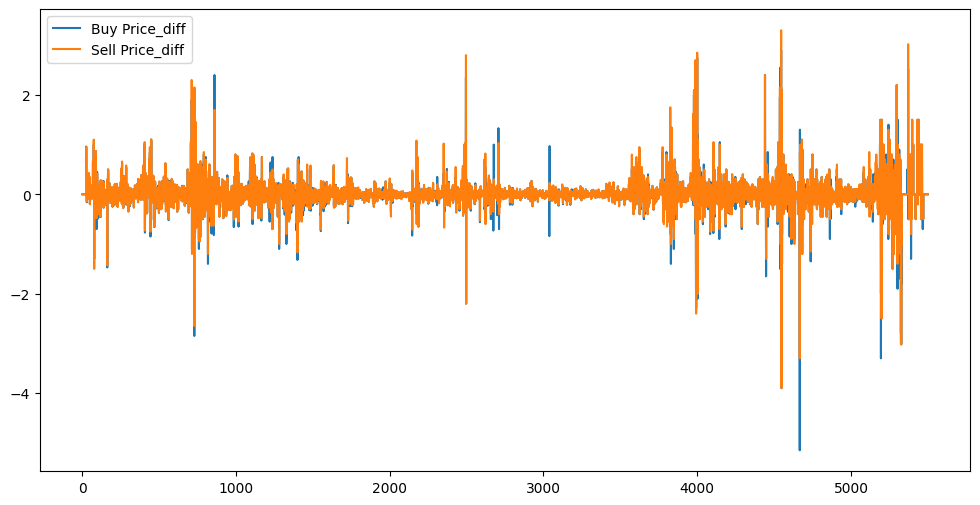

In [11]:
#Sai phân bậc 1
df_clean['Buy Price_diff'] = df_clean['Buy Price'].diff().dropna()
df_clean['Sell Price_diff'] = df_clean['Sell Price'].diff().dropna()

#Vẽ dữ liệu để xem chuỗi thời gian có tính dừng không
df_clean[['Buy Price_diff', 'Sell Price_diff']].plot(figsize=(12, 6))

In [12]:
#Kiểm định lại xem dữ liệu đã dừng chưa
from statsmodels.tsa.stattools import adfuller

# Lấy p-value từ ADF test
pvalue_buy = adfuller(df_clean['Buy Price_diff'].dropna())[1]
pvalue_sell = adfuller(df_clean['Sell Price_diff'].dropna())[1]

# In kết quả
print(f"Buy Price_diff - p-value: {pvalue_buy:.4f}")
print(f"Sell Price_diff - p-value: {pvalue_sell:.4f}")


Buy Price_diff - p-value: 0.0000
Sell Price_diff - p-value: 0.0000


Phân tích thành phần mùa vụ

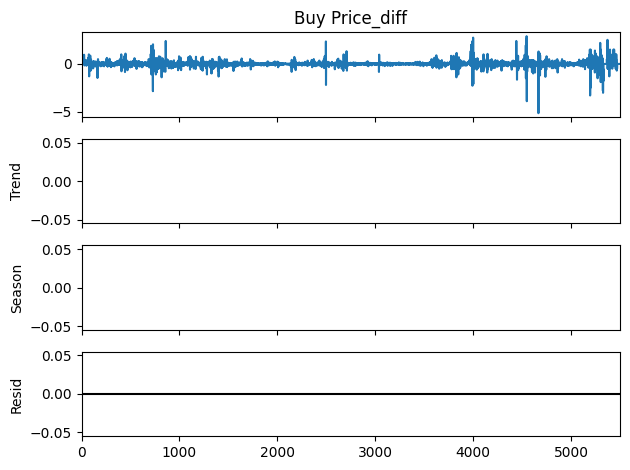

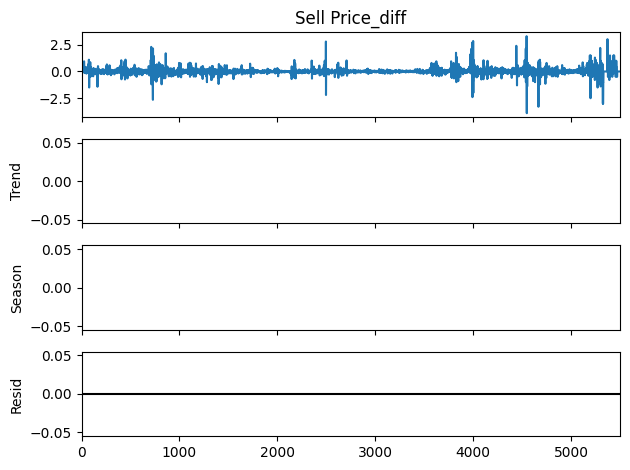

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Phân tách chuỗi thời gian Buy Price
stl_buy = STL(df_clean['Buy Price_diff'], period=12)  # period=12 cho chu kỳ hàng năm (dữ liệu hàng tháng)
result_buy = stl_buy.fit()

# Trực quan hóa kết quả phân tách cho Buy Price
result_buy.plot()
plt.show()

# Phân tách chuỗi thời gian Sell Price
stl_sell = STL(df_clean['Sell Price_diff'], period=12)  # period=12 cho chu kỳ hàng năm (dữ liệu hàng tháng)
result_sell = stl_sell.fit()

# Trực quan hóa kết quả phân tách cho Sell Price
result_sell.plot()
plt.show()

## 3. Xác định các tham số ARIMA (p, d, q)

### Lựa chọn tham số q, p bằng cách xây dựng hàm tự động

In [14]:
import pmdarima as pm

# Hàm tự động tìm các giá trị p, d, q tốt nhất
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                               start_p=1,
                               start_q=1,
                               max_p=10,
                               max_q=10,
                               d=1,        # Vì thực hiện sai phân lần 1
                               seasonal=False,    # Không có tính chu kỳ
                               trace=True)        # In quá trình tìm kiếm tham số
    return automodel

arimamodel(df_clean['Buy Price'].dropna())

ModuleNotFoundError: No module named 'pmdarima'

## 4. Xây dựng và đánh giá mô hình ARIMA

#### 4.1. Giá mua

In [17]:
from statsmodels.tsa.arima.model import ARIMA
# Xây dựng mô hình ARIMA cho giá mua
model = ARIMA(df_clean['Buy Price'], order=(0, 1, 0))
model_fit_Buy = model.fit()
# Tóm tắt mô hình
print(model_fit_Buy.summary())

                               SARIMAX Results                                
Dep. Variable:              Buy Price   No. Observations:                 5501
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1050.671
Date:                Thu, 10 Jul 2025   AIC                           2103.342
Time:                        23:51:04   BIC                           2109.954
Sample:                             0   HQIC                          2105.648
                               - 5501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0858      0.000    265.336      0.000       0.085       0.086
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):            564051.15
Prob(Q):                              0.46   Pr

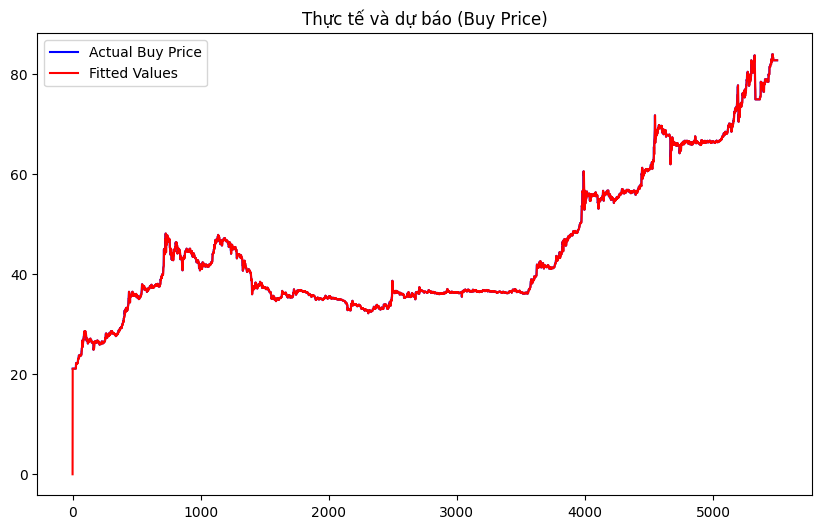

In [18]:
# Vẽ biểu đồ giá trị thực tế và giá trị dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_clean['Buy Price'], color='blue', label='Actual Buy Price')
plt.plot(model_fit_Buy.fittedvalues, color='red', label='Fitted Values')
plt.title("Thực tế và dự báo (Buy Price)")
plt.legend()
plt.show()

In [19]:
# Tính toán sai số
actual = df_clean['Buy Price'].iloc[1:]  # Bỏ đi phần tử đầu do sai khác của tích phân (d=1)
fitted = model_fit_Buy.fittedvalues
# MAD
mad = np.mean(np.abs(actual - fitted))
# SSE
sse = np.sum((actual - fitted) ** 2)
print("Mean Absolute Deviation (MAD):", mad)
print("Sum of Squared Errors (SSE):", sse)

Mean Absolute Deviation (MAD): 0.1298927272727273
Sum of Squared Errors (SSE): 471.8629


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = df_clean['Buy Price']
y_pred = model_fit_Buy.predict()
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mse**0.5
print("\nĐánh giá mô hình cho Buy Price:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")



Đánh giá mô hình cho Buy Price:
MSE: 0.1669
MAE: 0.1337
RMSE: 0.4086


### 4.2. Giá bán

In [21]:
from statsmodels.tsa.arima.model import ARIMA
# Xây dựng mô hình ARIMA cho giá mua
model = ARIMA(df_clean['Sell Price'], order=(0, 1, 0))
model_fit_Sell = model.fit()
# Tóm tắt mô hình
print(model_fit_Sell.summary())

                               SARIMAX Results                                
Dep. Variable:             Sell Price   No. Observations:                 5501
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -891.435
Date:                Thu, 10 Jul 2025   AIC                           1784.869
Time:                        23:52:31   BIC                           1791.482
Sample:                             0   HQIC                          1787.176
                               - 5501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0810      0.000    237.447      0.000       0.080       0.082
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            350629.14
Prob(Q):                              0.84   Pr

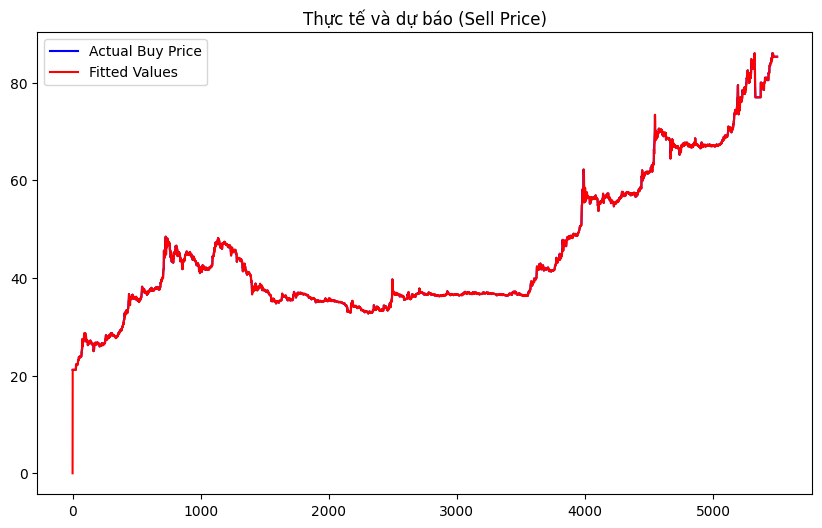

In [22]:
# Vẽ biểu đồ giá trị thực tế và giá trị dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_clean['Sell Price'], color='blue', label='Actual Buy Price')
plt.plot(model_fit_Sell.fittedvalues, color='red', label='Fitted Values')
plt.title("Thực tế và dự báo (Sell Price)")
plt.legend()
plt.show()

In [23]:
# Tính toán sai số
actual = df_clean['Sell Price'].iloc[1:]  # Bỏ đi phần tử đầu do sai khác của tích phân (d=1)
fitted = model_fit_Sell.fittedvalues
# MAD
mad = np.mean(np.abs(actual - fitted))
# SSE
sse = np.sum((actual - fitted) ** 2)
print("Mean Absolute Deviation (MAD):", mad)
print("Sum of Squared Errors (SSE):", sse)

Mean Absolute Deviation (MAD): 0.1282490909090909
Sum of Squared Errors (SSE): 445.3161


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = df_clean['Sell Price']
y_pred = model_fit_Sell.predict()
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mse**0.5
print("\nĐánh giá mô hình cho Sell Price:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")



Đánh giá mô hình cho Sell Price:
MSE: 0.1626
MAE: 0.1321
RMSE: 0.4032


## 5. DỰ BÁO KẾT QUẢ BẰNG MÔ HÌNH ARIMA

In [25]:
#Dự báo giá mua trong 10 ngày tiếp theo
model_fit_Buy.forecast(10)

5501    82.8
5502    82.8
5503    82.8
5504    82.8
5505    82.8
5506    82.8
5507    82.8
5508    82.8
5509    82.8
5510    82.8
Name: predicted_mean, dtype: float64

In [26]:
#Dự báo giá mua trong 10 ngày tiếp theo
model_fit_Buy.forecast(10)

5501    82.8
5502    82.8
5503    82.8
5504    82.8
5505    82.8
5506    82.8
5507    82.8
5508    82.8
5509    82.8
5510    82.8
Name: predicted_mean, dtype: float64